##### Comparing actual hydropower generation with simulated using physically based equation

Four hydropower is selected for the purpose
1. Crystal Dam - United States
2. Wanapum Dam - USA
3. Jupia Dam - Brazil
4. Estreito - Brazil

In [4]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [5]:
path = "/home/shah0012/GloHydroRes/Output_data/"
hydropower_data = pd.read_excel(path + "glohydrores_v1.xlsx",  header = 0, sheet_name = "data")

us_generation_data = pd.read_csv("/home/shah0012/GloHydroRes/Input_data/US_actual_generation_data/RectifHyd_v1.0.csv", header=27) # US monthly hydropower generation data
month_dict = {'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4, 'May' : 5, 'Jun' : 6, 'Jul' : 7, 'Aug' : 8, 'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12}
us_generation_data["month"] =  us_generation_data.month.map(month_dict)
us_generation_data = us_generation_data[["EIA_ID", "plant", "year", "month", "RectifHyd_MWh", "EIA_MWh", "recommended_data"]] 
us_generation_data = us_generation_data[us_generation_data.year != 2020]
us_generation_data["dates"] = pd.to_datetime(us_generation_data[['year', 'month']].assign(DAY = 1))
us_generation_data["final_generation_MWh"] =  np.where(us_generation_data["recommended_data"] == "RectifHyd", us_generation_data["RectifHyd_MWh"],  us_generation_data["EIA_MWh"])
us_generation_data["actual_generation_MW"]  = us_generation_data.final_generation_MWh/(us_generation_data.dates.dt.days_in_month*24)


HILARRI_data = gpd.read_file("/home/shah0012/GloHydroRes/Input_data/HILARRI_v1_1_Shapefile/" + "HILARRI_v1_1_Public.shp") # HILARRI database



brazil_ons_generation_data = pd.read_csv("/home/shah0012/GloHydroRes/Input_data/Brazil_ons_actual_generation_data/brazil_monthly_ons_data_2000_2021.csv")
brazil_ons_generation_data  = brazil_ons_generation_data[["plant_name", "datetime", "generation_value"]]
brazil_ons_generation_data.rename(columns = {"datetime" : "dates", "generation_value" : "actual_generation_MW"}, inplace=True)

brazil_ons_generation_data.dates = pd.to_datetime(brazil_ons_generation_data.dates)
brazil_ons_generation_data["dates"] =  brazil_ons_generation_data.dates.where(brazil_ons_generation_data.dates.dt.is_month_start, brazil_ons_generation_data.dates - pd.offsets.MonthBegin(1))


def data_prepare(plant_ID = "hc0010_p01", streamflow_source = "GRDC", streamflow_station_ID = 4152651, plant_name = "JupiÃ¡"):
    selected_plant =  hydropower_data[hydropower_data["plant_source_id"] == plant_ID]
    head_m = selected_plant.head_m.iloc[0]
    dam_height_m = selected_plant.dam_height_m.iloc[0]
    #plant_name = selected_plant.name.iloc[0]
    country_name = selected_plant.country.iloc[0]

    if streamflow_source == "GRDC":
        streamflow_data = xr.open_dataset("/home/shah0012/GloHydroRes/Input_data/GRDC/GRDC-Monthly.nc")
        streamflow_station_data  = streamflow_data.sel(id=streamflow_station_ID).runoff_mean.to_dataframe()
        streamflow_station_data = streamflow_station_data.dropna()
        streamflow_station_data.reset_index(inplace=True)
        streamflow_station_data.rename(columns = {"time" : "dates"}, inplace=True)
        actual_hydropower_generation_data =  us_generation_data[us_generation_data.EIA_ID == int(HILARRI_data[HILARRI_data.eha_ptid == plant_ID].eia_ptid.values[0])]
        actual_hydropower_generation_data  = actual_hydropower_generation_data[["dates", "actual_generation_MW"]]
        streamflow_station_data = pd.merge(streamflow_station_data, actual_hydropower_generation_data, on = "dates")
        
    
    
    elif streamflow_source == "CAMEL":
        discharge_path = "/home/shah0012/GloHydroRes/Input_data/Brazil_camel_dataset/"
        streamflow_station_data = pd.read_csv(f"{str(discharge_path)}/{streamflow_station_ID}_streamflow_m3s.txt", sep = '\s+')
        streamflow_station_data["dates"] = pd.to_datetime(streamflow_station_data[['year', 'month', "day"]])
        streamflow_station_data = streamflow_station_data[["dates", "streamflow_m3s"]]
        streamflow_station_data = streamflow_station_data.resample("M", on = "dates").mean().reset_index()
        streamflow_station_data["dates"] = streamflow_station_data.dates.where(streamflow_station_data.dates.dt.is_month_start, streamflow_station_data.dates - pd.offsets.MonthBegin(1))
        streamflow_station_data.rename(columns = {"streamflow_m3s" : "runoff_mean"}, inplace=True)       
        #streamflow_station_data.set_index("dates", inplace=True)
        actual_hydropower_generation_data = brazil_ons_generation_data[brazil_ons_generation_data.plant_name == plant_name]
        streamflow_station_data = pd.merge(streamflow_station_data, actual_hydropower_generation_data, on = "dates")
        
        
    
    
    head_physical_generation = (streamflow_station_data.runoff_mean*head_m*9.81*997)/1000000
    dam_height_physical_generation = (streamflow_station_data.runoff_mean*dam_height_m*9.81*997)/1000000
    station_generation_simulation = head_physical_generation.to_frame()
    station_generation_simulation.rename(columns={"runoff_mean" : "reported_head"}, inplace=True)
    station_generation_simulation["dam_height"] = dam_height_physical_generation.values
    station_generation_simulation["actual_generation"] = streamflow_station_data.actual_generation_MW
    station_generation_simulation["dates"] = streamflow_station_data.dates

    return station_generation_simulation, head_m, dam_height_m, plant_name, country_name


CRYSTAL_generation_simulation, crystal_head, crystal_dam_height, crystal_plant_name, cyrstal_country_name = data_prepare()
WANAPUM_generation_simulation, WANAPUM_head, WANAPUMl_dam_height, WANAPUM_plant_name, WANAPUM_country_name = data_prepare(plant_ID="hc1250_p01", streamflow_source="GRDC", streamflow_station_ID=4115203)
Jup_generation_simulation, Jup_head, Jup_dam_height, Jup_plant_name, Jup_country_name = data_prepare(plant_ID="BRA0001282", streamflow_source="CAMEL", streamflow_station_ID=63007080, plant_name= "JupiÃ¡")
Estreito_generation_simulation, Estreito_head, Estreito_dam_height, Estreito_plant_name, Estreito_country_name = data_prepare(plant_ID="BRA0028863", streamflow_source="CAMEL", streamflow_station_ID=23600000, plant_name= "Estreito")


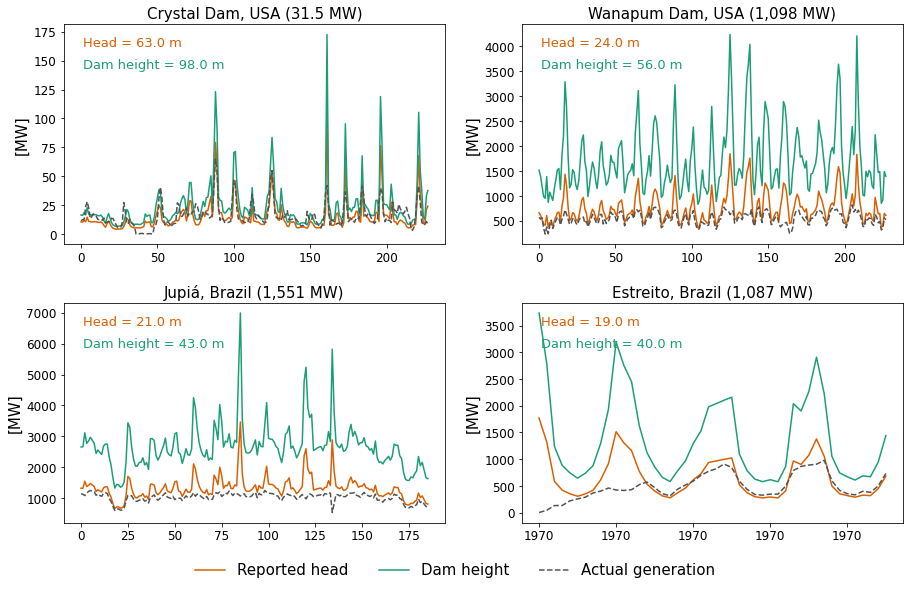

In [8]:
# Brazil generation data
dam_height_color = "#1b9e77"
head_color = "#d95f02"
actual_generation_color = "#525252"



import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 2, figsize=[13,8])

#CRYSTAL_generation_simulation.plot(x= "dates", y= "reported_head", ax=axes[0, 0], color="#1b9e77")
#CRYSTAL_generation_simulation.plot(x="dates", y= "dam_height", ax=axes[0, 0], color="#d95f02")
#CRYSTAL_generation_simulation.plot(x = "dates", y = "actual_generation",  ax = axes[0,0], color = ["#252525"])

axes[0,0].plot(
        CRYSTAL_generation_simulation.index,
        CRYSTAL_generation_simulation.reported_head,
        label="Reported head", c = head_color
    )
axes[0,0].plot(
        CRYSTAL_generation_simulation.index,
        CRYSTAL_generation_simulation.dam_height,
        label="Dam height", c = dam_height_color
    )

axes[0,0].plot(
        CRYSTAL_generation_simulation.index,
        CRYSTAL_generation_simulation.actual_generation,
        label="Actual generation", c = actual_generation_color,
        linestyle = "--"
    )

axes[0,0].set_ylabel("[MW]", size = 15)
axes[0,0].tick_params(labelsize = 12)
axes[0,0].annotate("Head = {} m".format(crystal_head.round()), (0.05, 0.9), xycoords = "axes fraction", fontsize=13, color = head_color)
axes[0,0].annotate("Dam height = {} m".format(crystal_dam_height.round()), (0.05, 0.8), xycoords = "axes fraction", fontsize=13, color = dam_height_color)
axes[0,0].set_title("Crystal Dam, USA (31.5 MW)", size = 15)


axes[0,1].plot(
        WANAPUM_generation_simulation.index,
        WANAPUM_generation_simulation.reported_head,
        label="Reported head", c = head_color
    )
axes[0,1].plot(
        WANAPUM_generation_simulation.index,
        WANAPUM_generation_simulation.dam_height,
        label="Dam height", c = dam_height_color
    )

axes[0,1].plot(
        WANAPUM_generation_simulation.index,
        WANAPUM_generation_simulation.actual_generation,
        label="Actual generation", c = actual_generation_color,
        linestyle = "--"
    )

axes[0,1].set_ylabel("[MW]", size = 15)
axes[0,1].tick_params(labelsize = 12)
axes[0,1].annotate("Head = {} m".format(WANAPUM_head.round()), (0.05, 0.9), xycoords = "axes fraction", fontsize=13, color = head_color)
axes[0,1].annotate("Dam height = {} m".format(WANAPUMl_dam_height.round()), (0.05, 0.8), xycoords = "axes fraction", fontsize=13, color = dam_height_color)
axes[0,1].set_title("Wanapum Dam, USA (1,098 MW)", size = 15)


axes[1,0].plot(
        Jup_generation_simulation.index,
        Jup_generation_simulation.reported_head,
        label="Reported head", c = head_color
    )
axes[1,0].plot(
        Jup_generation_simulation.index,
        Jup_generation_simulation.dam_height,
        label="Dam height", c = dam_height_color
    )

axes[1,0].plot(
        Jup_generation_simulation.index,
        Jup_generation_simulation.actual_generation,
        label="Actual generation", c = actual_generation_color,
        linestyle = "--"

    )


axes[1,0].set_ylabel("[MW]", size = 15)
axes[1,0].tick_params(labelsize = 12)
axes[1,0].annotate("Head = {} m".format(Jup_head.round()), (0.05, 0.9), xycoords = "axes fraction", fontsize=13, color = head_color)
axes[1,0].annotate("Dam height = {} m".format(Jup_dam_height.round()), (0.05, 0.8), xycoords = "axes fraction", fontsize=13, color = dam_height_color)
axes[1,0].set_title("Jupiá, Brazil (1,551 MW)", size = 15)



axes[1,1].plot(
        Estreito_generation_simulation.index,
        Estreito_generation_simulation.reported_head,
        label="Reported head", c = head_color
    )
axes[1,1].plot(
        Estreito_generation_simulation.index,
        Estreito_generation_simulation.dam_height,
        label="Dam height", c = dam_height_color
    )

axes[1,1].plot(
        Estreito_generation_simulation.index,
        Estreito_generation_simulation.actual_generation,
        label="Actual generation", c = actual_generation_color,
        linestyle = "--"
    )

axes[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[1,1].set_ylabel("[MW]", size = 15)
axes[1,1].tick_params(labelsize = 12)
axes[1,1].annotate("Head = {} m".format(Estreito_head.round()), (0.05, 0.9), xycoords = "axes fraction", fontsize=13, color = head_color)
axes[1,1].annotate("Dam height = {} m".format(Estreito_dam_height.round()), (0.05, 0.8), xycoords = "axes fraction", fontsize=13, color = dam_height_color)
axes[1,1].set_title("Estreito, Brazil (1,087 MW)", size = 15)


handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False, fontsize=15, title_fontsize=15)




plt.tight_layout(pad=2);

plt.savefig("/home/shah0012/GloHydroRes/Figure/"
     + "monhtlyhydropower_simulation.pdf", bbox_inches='tight');
